# Transfer Learning: KITTI Monkey Dataset Classification
### Using RESNET50

> Import libraries

In [1]:
import numpy as np
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt

from constants import *

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('Running on : ',device)

Running on :  cuda


>> Generate Dataloaders for train, validation and test data.

In [3]:
validation_split = 0.2
visualize_YN = True

In [6]:
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
# Normalize
norm = torchvision.transforms.Normalize(mean=DATASETMEAN,std=DATASETSD)
transform_lst = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),norm,torchvision.transforms.Resize((300, 300))])

# Read Train dataset
train_dataset = torchvision.datasets.ImageFolder('./training', transform=transform_lst)

# Randomly split train dataset to train and validation with ratio 1:0.2
all_point_idx = list(range(len(train_dataset)))
print('Total data points in train:',len(all_point_idx))
np.random.shuffle(all_point_idx)        # Shuffle indices
slice_idx = int(np.floor(validation_split * len(train_dataset)))     # index to slice at
print('Slice Index= ',slice_idx)
train_idx = all_point_idx[slice_idx:] 
print('Data points in train after split:',len(train_idx))
train_sampler = SubsetRandomSampler(train_idx)


valid_dataset = train_dataset
valid_idx = all_point_idx[:slice_idx]
print('Data points in validation set:',len(valid_idx))
valid_sampler = SubsetRandomSampler(valid_idx)

# Generate Python iterable over dataset to train and test
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, sampler=valid_sampler)

test_dataset = torchvision.datasets.ImageFolder('./validation', transform=transform_lst)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=16,shuffle = True, drop_last=True)

Total data points in train: 1097
Slice Index=  219
Data points in train after split: 878
Data points in validation set: 219


Sample visualization


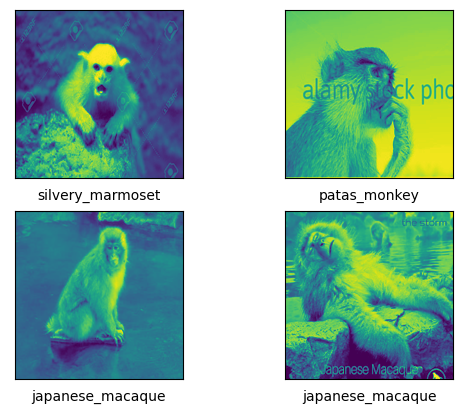

In [7]:
if visualize_YN:
    # Visualize a loaded sampler
    data_small = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1, pin_memory=True)
    data_iter = iter(data_small)
    X, classes_ = data_iter.next()
    X = X.numpy()
    fig, axes = plt.subplots(2, 2)
    print('Sample visualization')
    for i, ax in enumerate(axes.flat):
        label = str(classes_[i])
        xlabel = label_dictionary[label[7]]
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(X[i, 0, :, :], interpolation='spline16')
    plt.show()
    

Remove the last
fully connected layers of the pretrained model and replace it with untrained fully
connected layers to classify the monkey species. During training, you will freeze
the convolutional layer parameters so that they remain the same and only update
the fully connected layers at the end. In this way, the convolutional layers act as
generalized feature extractors that have already been pretrained on millions of other
images (that werent necessarily all monkeys) while the fully connected layers are able
to take these features and classify our images

> Download ResNet50

In [9]:
from torchvision import models

In [10]:
model = models.resnet50(pretrained=True).to(device) 

C:\Users\kavya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\kavya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\kavya/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
# Freeze Conv layer parameters so they remain same
for param in model.parameters():
    param.requires_grad = False  

In [19]:
# Remove the last fully connected layers of the pretrained model and replace it with untrained fully connected layers
model.fc =  nn.Sequential(nn.Linear(2048, 128),nn.ReLU(inplace=True),nn.Linear(128, 10))
model = model.to(device=device)

>> Method to evaluate model 

In [20]:
def get_score(loader, model)->list:
    ''' Returns score evaluated for data in 'loader' using 'model' '''
    score = []
    model.eval()
    count_true = 0
    total_ = 0 
    #print(loader)   
    with torch.no_grad():
        for image, label in loader:
            #print(' inside for x, y in loader')
            image = image.to(device=device, dtype=torch.float32)
            label = label.to(device=device, dtype=torch.long)
            # Predict
            _, y_hat = (model(image)).max(1)
            # print(label)
            # print(y_hat)
            count_true += (y_hat == label).sum()
            total_ += y_hat.size(0)
        s = float(count_true) / total_
        score.append(s)
        print('Correct prediction for %d / %d samples. Accuracy = (%.2f)' % (count_true, total_, 100 * s))
        return score


>> Train method for model

In [21]:
def train(model, optimizer, epochs=1):
    #print(model)
    validation_score = []
    lst_loss = []
    # print('a')
    model = model.to(device=device)
    #print('b')
    for i in range(epochs):
        #print(i)
        for batch, (img, lbl) in enumerate(train_loader):
            # print(batch)
            # print(img.shape)
            # print(lbl.shape)
            model.train()
            img = img.to(device=device, dtype=torch.float32)
            lbl = lbl.to(device=device, dtype=torch.long)
            # print(img.shape)
            #print(lbl)
            scores = model(img)
            # Computes the cross entropy loss between input and target.
            loss = F.cross_entropy(scores, lbl)
            # Optimizer
            optimizer.zero_grad()
            # Compute the gradient of current tensor w.r.t. graph leaves
            loss.backward()
            # Step
            
            optimizer.step()
            # Print result every 50th step
            if batch % 50 == 0:
                # Print Loss
                print('Epoch %d, Loss = %.4f' % (batch, loss.item()))
                # Evaluate accuracy and print
                validation_score.append(get_score(valid_loader, model))
                lst_loss.append(loss.item())
    best_val = []
    for a in validation_score:
        best_val.append(a[np.argmax(a)])
    return best_val,lst_loss,model


In [22]:
# # Define optimizers to evaluate with:
optimizers = [optim.SGD(model.parameters(), lr=0.00215),
              optim.Adagrad(model.parameters(), lr=0.0023, lr_decay=0.75),
              optim.Adam(model.parameters(), lr=0.0015)]

# Define optimizers to evaluate with:
# optimizers = [optim.Adam(model.parameters(), lr=0.003)]


In [24]:
#model = neural_net
best_val,lst_loss,best_model = train(model, optimizers[0], epochs=50)


Epoch 0, Loss = 2.2733
Correct prediction for 58 / 219 samples. Accuracy = (26.48)
Epoch 50, Loss = 2.1552
Correct prediction for 62 / 219 samples. Accuracy = (28.31)
Epoch 0, Loss = 2.2245
Correct prediction for 77 / 219 samples. Accuracy = (35.16)
Epoch 50, Loss = 2.1569
Correct prediction for 96 / 219 samples. Accuracy = (43.84)
Epoch 0, Loss = 2.0562
Correct prediction for 94 / 219 samples. Accuracy = (42.92)
Epoch 50, Loss = 2.0682
Correct prediction for 109 / 219 samples. Accuracy = (49.77)
Epoch 0, Loss = 1.9094
Correct prediction for 100 / 219 samples. Accuracy = (45.66)
Epoch 50, Loss = 1.9097
Correct prediction for 136 / 219 samples. Accuracy = (62.10)
Epoch 0, Loss = 2.0197
Correct prediction for 138 / 219 samples. Accuracy = (63.01)
Epoch 50, Loss = 1.9323
Correct prediction for 156 / 219 samples. Accuracy = (71.23)
Epoch 0, Loss = 1.8850
Correct prediction for 147 / 219 samples. Accuracy = (67.12)
Epoch 50, Loss = 1.9272
Correct prediction for 158 / 219 samples. Accuracy =

In [25]:
best_val[np.argmax(best_val)]

0.9908675799086758

In [26]:
test_acc_sgd = get_score(test_loader, best_model)

Correct prediction for 270 / 272 samples. Accuracy = (99.26)


## Plot Results

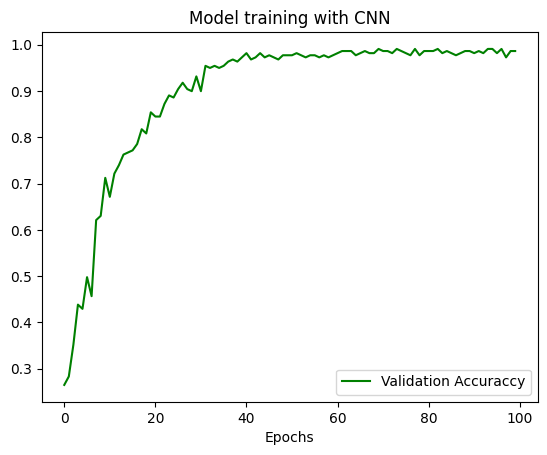

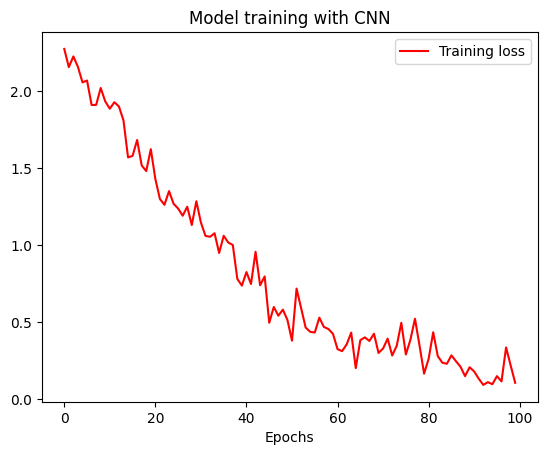

In [27]:
plt.plot(range(len(best_val)), best_val, 'g', label='Validation Accuraccy')
plt.title('Model training with CNN')
plt.xlabel('Epochs')
plt.legend()
plt.show()
plt.plot(range(len(lst_loss)), lst_loss, 'r', label='Training loss')
plt.title('Model training with CNN')
plt.xlabel('Epochs')
plt.legend()
plt.show()